In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [ ]:
model = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    classes=1000,
    classifier_activation="softmax",
)

574717952/574710816 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis = 0)
    return x

In [ ]:
def load_valid_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = x / 255.0
    x = np.expand_dims(x, axis = 0)
    return x

In [ ]:
img_tensor_1 = load_image('/content/gdrive/MyDrive/작업용사진들/20210510_191809.jpg')
img_tensor_2 = load_image('/content/gdrive/MyDrive/작업용사진들/20210409_145311.jpg')
img_tensor_3 = load_image('/content/gdrive/MyDrive/작업용사진들/20210410_202625.jpg')
img_tensor_4 = load_image('/content/gdrive/MyDrive/작업용사진들/20210406_210025.jpg')
img_tensor_5 = load_image('/content/gdrive/MyDrive/작업용사진들/Screenshot_20210612-205933_Samsung Internet.jpg')
img_tensor_6 = load_image('/content/gdrive/MyDrive/작업용사진들/Screenshot_20210612-210003_Samsung Internet.jpg')

In [ ]:
img_1 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/20210510_191809.jpg')
img_2 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/20210409_145311.jpg')
img_3 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/20210410_202625.jpg')
img_4 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/20210406_210025.jpg')
img_5 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/Screenshot_20210612-205933_Samsung Internet.jpg')
img_6 = load_valid_image('/content/gdrive/MyDrive/작업용사진들/Screenshot_20210612-210003_Samsung Internet.jpg')

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # model that outputs last_conv_activation & final_prediction, given input image tensor
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # 
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # dimension 0 is batch_size -> eliminate the dimension
    grads = grads[0]
    last_conv_layer_output = last_conv_layer_output[0]
    # GAP on grads -> weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    grad_cam = np.zeros(dtype=np.float32, shape = last_conv_layer_output.shape[0:2])
    # linear combination with weights of pooled_grads
    for i, a in enumerate(pooled_grads):
        grad_cam += a * last_conv_layer_output[:,:,i]
    grad_cam = grad_cam.numpy()
    # upsampling using bilinear interpolation
    grad_cam = cv2.resize(grad_cam, (224, 224))
    # ReLu activation
    grad_cam = np.maximum(grad_cam, 0)
    # Normalization
    grad_cam = grad_cam / grad_cam.max()
    
    return grad_cam


In [ ]:
last_conv_layer_name = 'block5_pool'
grad_cam_heatmap_1 = make_gradcam_heatmap(img_tensor_1, model, last_conv_layer_name)
grad_cam_heatmap_2 = make_gradcam_heatmap(img_tensor_2, model, last_conv_layer_name)
grad_cam_heatmap_3 = make_gradcam_heatmap(img_tensor_3, model, last_conv_layer_name, pred_index = 889)

Text(0.5, 1.0, 'violin')

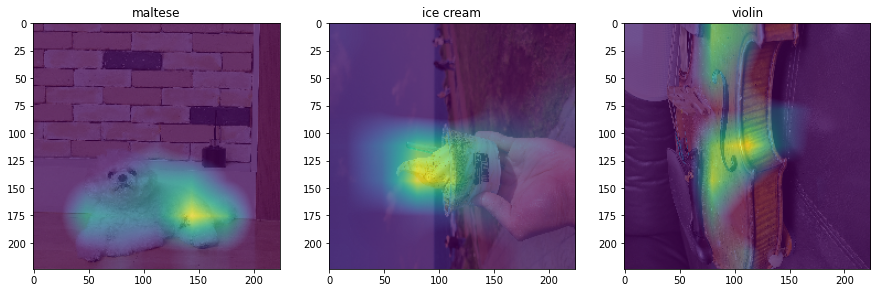

In [ ]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(131)
plt.imshow(img_1.reshape(224,224,3))
plt.imshow(grad_cam_heatmap_1, alpha = 0.7)
plt.title('maltese')

plt.subplot(132)
plt.imshow(img_2.reshape(224,224,3))
plt.imshow(grad_cam_heatmap_2, alpha = 0.7)
plt.title('ice cream')

plt.subplot(133)
plt.imshow(img_3.reshape(224,224,3))
plt.imshow(grad_cam_heatmap_3, alpha = 0.7)
plt.title('violin')